# **Entrenamiento de TimeSformer para Detección de Violencia Escolar**

# Sección 1: Configuración del Entorno

In [1]:
# Instalación de paquetes necesarios
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116
!pip install transformers pytorch_lightning scikit-learn matplotlib seaborn pandas numpy
!pip install pytorchvideo opencv-python imgaug tensorboard tqdm wandb nlgeval
!pip install av onnx onnxruntime

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu116
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 41.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninst

In [ ]:
# Modificar la instalación de paquetes para especificar versiones compatibles
!pip install torch==1.12.1 torchvision==0.13.1 torchaudio==0.12.1 --extra-index-url https://download.pytorch.org/whl/cu116
!pip install transformers==4.27.0 pytorch_lightning==1.9.0 scikit-learn==1.1.3 matplotlib==3.6.3 seaborn==0.12.2 pandas==1.5.3 numpy==1.23.5
!pip install pytorchvideo==0.1.5 opencv-python==4.7.0.72 imgaug==0.4.0 tensorboard==2.12.0 tqdm==4.65.0 wandb==0.15.0
!pip install av==10.0.0 onnx==1.13.1 onnxruntime==1.14.1 nlgeval==2.3.0 captum==0.6.0

In [2]:
# Añadir manejo de errores al montar Google Drive
try:
    from google.colab import drive
    drive.mount('/content/drive')
    print("Google Drive montado correctamente.")
except Exception as e:
    print(f"Error al montar Google Drive: {e}")
    print("Continuando sin acceso a Google Drive. Asegúrate de montar manualmente.")


Mounted at /content/drive
Google Drive montado correctamente.


In [3]:
# Verificar si tenemos GPU disponible
import torch
print(f"¿GPU disponible?: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Dispositivo actual: {torch.cuda.get_device_name(0)}")
    print(f"Capacidad de memoria: {torch.cuda.get_device_properties(0).total_memory / 1e9} GB")


# Configurar directorios
import os
import sys
import random
import numpy as np

# Rutas principales
DATASET_PATH = "/content/drive/MyDrive/dataset_violencia"  # Ajusta la ruta según tu estructura en Google Drive
CHECKPOINTS_PATH = "/content/drive/MyDrive/Proyecto-Deteccion-Violencia/timesformer/checkpoints"
RESULTS_PATH = "/content/drive/MyDrive/Proyecto-Deteccion-Violencia/timesformer/results"

# Crear directorios si no existen
for directory in [CHECKPOINTS_PATH, RESULTS_PATH]:
    if not os.path.exists(directory):
        os.makedirs(directory)

# Semilla para reproducibilidad
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

print("Entorno configurado correctamente.")

¿GPU disponible?: True
Dispositivo actual: Tesla T4
Capacidad de memoria: 15.828320256 GB
Entorno configurado correctamente.


In [4]:
# Verificar que la estructura de directorios del dataset existe
def verify_dataset_structure(dataset_path):
    """Verifica que la estructura del dataset sea correcta"""
    expected_dirs = [
        os.path.join(dataset_path, 'train', 'violence'),
        os.path.join(dataset_path, 'train', 'no_violence'),
        os.path.join(dataset_path, 'val', 'violence'),
        os.path.join(dataset_path, 'val', 'no_violence'),
        os.path.join(dataset_path, 'test', 'violence'),
        os.path.join(dataset_path, 'test', 'no_violence')
    ]

    for directory in expected_dirs:
        if not os.path.exists(directory):
            print(f"ADVERTENCIA: No existe el directorio {directory}")
            return False

    return True

# Verificar estructura
is_structure_valid = verify_dataset_structure(DATASET_PATH)
if not is_structure_valid:
    print("La estructura del dataset no es la esperada. Verifica las rutas.")

## Sección 2: Exploración y Preparación de Datos

Total de videos en el dataset: 10300


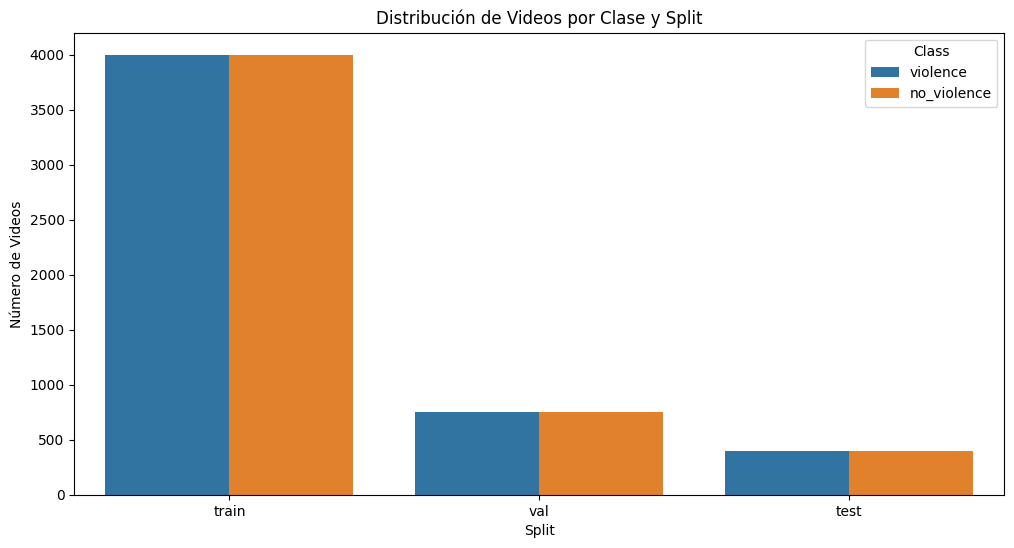

Ejemplos de videos en el dataset:
    Split        Class                                        File  Duration  \
0   train     violence                  violencia_directa_1379.mp4  6.133333   
1   train     violence  violencia_directa_1102_horizontal_flip.mp4  5.133333   
2   train     violence                  violencia_directa_1930.mp4  5.466667   
3   train     violence                   violencia_directa_674.mp4  5.133333   
4   train     violence  violencia_directa_1526_horizontal_flip.mp4  5.000000   
5   train  no_violence        no_violencia_237_horizontal_flip.mp4  5.133333   
6   train  no_violence                        no_violencia_147.mp4  4.133333   
7   train  no_violence                        no_violencia_396.mp4  4.066667   
8   train  no_violence                       no_violencia_1635.mp4  3.133333   
9   train  no_violence       no_violencia_2375_horizontal_flip.mp4  5.133333   
10    val     violence   violencia_directa_677_horizontal_flip.mp4  5.133333   
11    

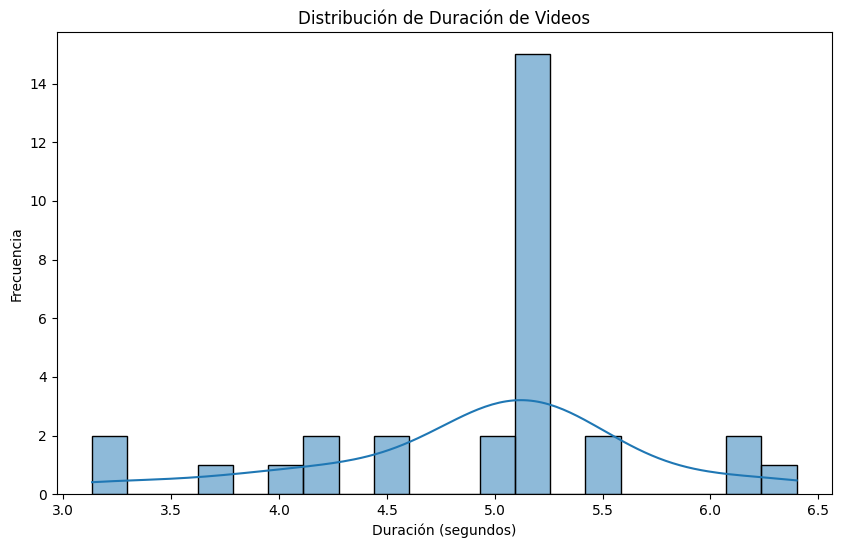

In [5]:
# Análisis del dataset
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter

# Estructura del dataset según documentación:
# dataset_violencia/
#   train/
#     no_violence/
#       no_violencia_001.mp4
#       ...
#     violence/
#       violencia_001.mp4
#       ...
#   val/
#     no_violence/
#     violence/
#   test/
#     no_violence/
#     violence/

def analyze_dataset(dataset_path):
    """Analiza la estructura y distribución del dataset"""
    splits = ['train', 'val', 'test']
    classes = ['violence', 'no_violence']

    stats = {}
    total_videos = 0

    for split in splits:
        stats[split] = {}
        split_path = os.path.join(dataset_path, split)

        for class_name in classes:
            class_path = os.path.join(split_path, class_name)
            if os.path.exists(class_path):
                videos = [f for f in os.listdir(class_path) if f.endswith('.mp4')]
                stats[split][class_name] = len(videos)
                total_videos += len(videos)
            else:
                stats[split][class_name] = 0

    return stats, total_videos

# Analizar el dataset
dataset_stats, total_count = analyze_dataset(DATASET_PATH)
print(f"Total de videos en el dataset: {total_count}")

# Crear un DataFrame para visualización
df_stats = pd.DataFrame(columns=['Split', 'Class', 'Count'])
for split, classes in dataset_stats.items():
    for class_name, count in classes.items():
        df_stats = pd.concat([df_stats, pd.DataFrame([{
            'Split': split,
            'Class': class_name,
            'Count': count
        }])], ignore_index=True)

# Visualizar distribución del dataset
plt.figure(figsize=(12, 6))
sns.barplot(x='Split', y='Count', hue='Class', data=df_stats)
plt.title('Distribución de Videos por Clase y Split')
plt.ylabel('Número de Videos')
plt.savefig(os.path.join(RESULTS_PATH, 'dataset_distribution.png'))
plt.show()

# Verificar duración de algunos videos para confirmar estructura
import av
import random

def check_video_samples(dataset_path, num_samples=5):
    """Verifica la duración y resolución de algunos videos de muestra"""
    splits = ['train', 'val', 'test']
    classes = ['violence', 'no_violence']
    samples = []

    try:
        # El código existente...
        for split in splits:
            for class_name in classes:
                class_path = os.path.join(dataset_path, split, class_name)
                if os.path.exists(class_path):
                    videos = [f for f in os.listdir(class_path) if f.endswith('.mp4')]
                    if videos:
                        sample = random.sample(videos, min(num_samples, len(videos)))
                        for video_file in sample:
                            video_path = os.path.join(class_path, video_file)
                            try:
                                container = av.open(video_path)
                                video_stream = container.streams.video[0]
                                duration = container.duration / 1000000  # en segundos
                                fps = video_stream.average_rate
                                frame_count = video_stream.frames
                                width = video_stream.width
                                height = video_stream.height

                                samples.append({
                                    'Split': split,
                                    'Class': class_name,
                                    'File': video_file,
                                    'Duration': duration,
                                    'FPS': fps,
                                    'Frames': frame_count,
                                    'Resolution': f"{width}x{height}"
                                })
                            except Exception as e:
                                print(f"Error al procesar {video_path}: {e}")
    except Exception as e:
        print(f"Error al procesar muestra de video: {e}")
        print("Verificar que los videos sean accesibles y estén en un formato válido.")

    if not samples:
        print("ADVERTENCIA: No se pudo extraer información de ninguna muestra de video.")

    return pd.DataFrame(samples)

# Revisar algunos ejemplos de videos
video_samples = check_video_samples(DATASET_PATH)
print("Ejemplos de videos en el dataset:")
print(video_samples)

# Resumen de características del dataset
print("\nResumen de duración (segundos):")
print(video_samples['Duration'].describe())

print("\nResumen de FPS:")
print(video_samples['FPS'].describe())

# Visualizar distribución de duración
plt.figure(figsize=(10, 6))
sns.histplot(video_samples['Duration'], bins=20, kde=True)
plt.title('Distribución de Duración de Videos')
plt.xlabel('Duración (segundos)')
plt.ylabel('Frecuencia')
plt.savefig(os.path.join(RESULTS_PATH, 'duration_distribution.png'))
plt.show()

## Sección 3: Construcción del DataLoader

In [6]:
!pip install pytorchvideo opencv-python imgaug tensorboard tqdm wandb nlgeval

  Using cached pytorchvideo-0.1.5.tar.gz (132 kB)
  Preparing metadata (setup.py) ... done
  Using cached imgaug-0.4.0-py2.py3-none-any.whl.metadata (1.8 kB)
ERROR: Could not find a version that satisfies the requirement nlgeval (from versions: none)
ERROR: No matching distribution found for nlgeval


In [7]:
# Sección 3: Construcción del DataLoader
# DataLoader para videos utilizando PyTorchVideo y Transformers
import torch
from torch.utils.data import Dataset, DataLoader
from pytorchvideo.data.encoded_video import EncodedVideo
from transformers import AutoImageProcessor
import av
import math
import numpy as np
from pathlib import Path
from tqdm.auto import tqdm

# Procesador de imágenes para TimeSformer
processor = AutoImageProcessor.from_pretrained("facebook/timesformer-base-finetuned-k400")

class ViolenceDetectionDataset(Dataset):
    def __init__(self, dataset_path, split, transform=None, num_frames=8, clip_duration=3):
        """
        Dataset para detección de violencia en videos
        Args:
            dataset_path: Ruta al dataset
            split: 'train', 'val' o 'test'
            transform: Transformaciones adicionales
            num_frames: Número de frames a extraer
            clip_duration: Duración del clip en segundos
        """
        self.dataset_path = Path(dataset_path)
        self.split = split
        self.transform = transform
        self.num_frames = num_frames
        self.clip_duration = clip_duration

        # Clases
        self.classes = ['no_violence', 'violence']
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}

        # Recopilar todos los videos
        self.video_paths = []
        self.labels = []

        for class_name in self.classes:
            class_path = self.dataset_path / split / class_name
            if class_path.exists():
                for video_file in class_path.glob('*.mp4'):
                    self.video_paths.append(str(video_file))
                    self.labels.append(self.class_to_idx[class_name])

        print(f"Split {split}: {len(self.video_paths)} videos")

    def __len__(self):
        return len(self.video_paths)

    # En sample_frames_from_video, mejorar la estimación cuando no hay información de frames:
    def sample_frames_from_video(self, video_path):
        """Extrae frames del video uniformemente espaciados"""
        try:
            container = av.open(video_path)
            video_stream = container.streams.video[0]

            # Obtener el número total de frames
            total_frames = video_stream.frames

            if total_frames == 0:  # Si no se puede determinar el número de frames
                # Estimamos basado en duración y fps
                duration = container.duration / 1000000  # en segundos
                fps = video_stream.average_rate
                if fps == 0:  # Si tampoco se puede determinar el fps
                    fps = 30  # Valor predeterminado común
                total_frames = max(int(duration * fps), self.num_frames)

            # Calcular índices de frames a extraer
            indices = np.linspace(0, total_frames - 1, self.num_frames, dtype=int)

            frames = []
            for i, frame in enumerate(container.decode(video=0)):
                if i in indices:
                    # Convertir a numpy array RGB
                    img = frame.to_ndarray(format='rgb24')
                    frames.append(img)

                    # Si ya tenemos suficientes frames, salimos
                    if len(frames) == self.num_frames:
                        break

            # Si no obtuvimos suficientes frames, repetimos el último
            while len(frames) < self.num_frames:
                if frames:
                    frames.append(frames[-1])
                else:
                    # Si no se obtuvo ningún frame, crear uno negro
                    frames.append(np.zeros((224, 224, 3), dtype=np.uint8))

            return frames

        except Exception as e:
            print(f"Error en sample_frames_from_video para {video_path}: {e}")
            # Crear frames vacíos
            return [np.zeros((224, 224, 3), dtype=np.uint8) for _ in range(self.num_frames)]

    # En ViolenceDetectionDataset.__getitem__, optimizar el manejo de errores:
    def __getitem__(self, idx):
        video_path = self.video_paths[idx]
        label = self.labels[idx]

        try:
            # Extraer frames del video
            frames = self.sample_frames_from_video(video_path)

            # Aplicar transformaciones si existen
            if self.transform:
                frames = [self.transform(frame) for frame in frames]

            # Procesar frames con el image processor de TimeSformer
            inputs = processor(images=frames, return_tensors="pt")
            pixel_values = inputs.pixel_values.squeeze(0)  # Eliminar dim de batch

            return {
                'pixel_values': pixel_values,
                'labels': torch.tensor(label, dtype=torch.long),
                'video_path': video_path
            }
        except Exception as e:
            print(f"Error procesando video {video_path}: {e}")
            # Crear un log para videos problemáticos
            with open('videos_error.log', 'a') as f:
                f.write(f"{video_path}: {str(e)}\n")

            # Devolver frames vacíos en caso de error
            dummy_frames = [np.zeros((224, 224, 3), dtype=np.uint8) for _ in range(self.num_frames)]
            inputs = processor(images=dummy_frames, return_tensors="pt")
            pixel_values = inputs.pixel_values.squeeze(0)

            return {
                'pixel_values': pixel_values,
                'labels': torch.tensor(label, dtype=torch.long),
                'video_path': video_path
            }

# Crear función de colación
def collate_fn(batch):
    pixel_values = torch.stack([item['pixel_values'] for item in batch])
    labels = torch.tensor([item['labels'] for item in batch])
    video_paths = [item['video_path'] for item in batch]

    return {
        'pixel_values': pixel_values,
        'labels': labels,
        'video_paths': video_paths
    }

# Crear dataloaders
def create_dataloaders(dataset_path, batch_size=8, num_workers=4):
    # Verificar disponibilidad de GPU y ajustar batch_size y num_workers
    if torch.cuda.is_available():
        # Obtener memoria disponible (en GB)
        gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1e9

        # Ajustar batch_size según memoria disponible
        if gpu_memory < 8:  # Menos de 8GB
            batch_size = min(batch_size, 4)
            num_workers = min(num_workers, 2)
            print(f"GPU con memoria limitada detectada. Ajustando batch_size={batch_size}, num_workers={num_workers}")
    else:
        # Sin GPU, reducir para evitar problemas de memoria
        batch_size = min(batch_size, 2)
        num_workers = min(num_workers, 2)
        print(f"No se detectó GPU. Ajustando batch_size={batch_size}, num_workers={num_workers}")


    train_dataset = ViolenceDetectionDataset(dataset_path, 'train')
    val_dataset = ViolenceDetectionDataset(dataset_path, 'val')
    test_dataset = ViolenceDetectionDataset(dataset_path, 'test')

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        collate_fn=collate_fn,
        pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        collate_fn=collate_fn,
        pin_memory=True
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        collate_fn=collate_fn,
        pin_memory=True
    )

    return train_loader, val_loader, test_loader

# Crear los dataloaders
batch_size = 8  # Ajustar según la memoria disponible en la GPU
train_loader, val_loader, test_loader = create_dataloaders(DATASET_PATH, batch_size=batch_size)

# Mostrar ejemplo de batch
batch = next(iter(train_loader))
print(f"Forma del batch de pixel_values: {batch['pixel_values'].shape}")
print(f"Forma del batch de labels: {batch['labels'].shape}")

ModuleNotFoundError: No module named 'pytorchvideo'

## Sección 4: Implementación del Modelo y Transfer Learning

In [ ]:
# Implementación del modelo con Transfer Learning
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import TimesformerForVideoClassification, get_cosine_schedule_with_warmup
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix,
                             roc_curve, precision_recall_curve, classification_report)
import time
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import wandb
import numpy as np


# Antes de cargar el modelo pre-entrenado, verificar disponibilidad
def check_model_availability(model_name):
    """Verifica que el modelo pretrained sea accesible"""
    try:
        from transformers import AutoConfig
        config = AutoConfig.from_pretrained(model_name)
        print(f"Modelo {model_name} disponible.")
        return True
    except Exception as e:
        print(f"Error al verificar disponibilidad del modelo {model_name}: {e}")
        print("Intenta descargar el modelo manualmente o verificar tu conexión a internet.")
        return False

# Verificar modelo
pretrained_model = "facebook/timesformer-base-finetuned-k400"
if not check_model_availability(pretrained_model):
    print("ADVERTENCIA: El modelo pre-entrenado no está disponible.")
    # Proporcionar alternativa
    pretrained_model = "facebook/timesformer-base-finetuned-k600"
    print(f"Intentando con modelo alternativo: {pretrained_model}")
    if not check_model_availability(pretrained_model):
        raise Exception("No se pudo acceder a ninguno de los modelos pre-entrenados.")


# Iniciar wandb para seguimiento de experimentos
wandb.init(project="violence-detection-timesformer", name="transfer_learning")

class ViolenceDetectionModel(nn.Module):
    def __init__(self, num_classes=2, pretrained_model="facebook/timesformer-base-finetuned-k400"):
        super(ViolenceDetectionModel, self).__init__()
        # Cargar modelo pre-entrenado
        self.timesformer = TimesformerForVideoClassification.from_pretrained(
            pretrained_model,
            num_labels=num_classes,
            ignore_mismatched_sizes=True
        )

        # Mostrar el número de parámetros
        total_params = sum(p.numel() for p in self.timesformer.parameters())
        print(f"Número total de parámetros: {total_params:,}")

        # Congelar todas las capas del modelo base inicialmente para transfer learning
        for param in self.timesformer.parameters():
            param.requires_grad = False

        # Descongelar solo la cabeza de clasificación
        for param in self.timesformer.classifier.parameters():
            param.requires_grad = True

    def forward(self, pixel_values):
        outputs = self.timesformer(pixel_values=pixel_values)
        return outputs.logits

    def unfreeze_top_layers(self, num_layers=4):
        """Descongela las capas superiores del modelo para fine-tuning"""
        # Primero aseguramos que todo está congelado
        for param in self.timesformer.parameters():
            param.requires_grad = False

        # Descongelar la cabeza de clasificación
        for param in self.timesformer.classifier.parameters():
            param.requires_grad = True

        # Descongelar las capas superiores del encoder
        transformer_layers = self.timesformer.timesformer.model.encoder.layer
        for i in range(len(transformer_layers) - num_layers, len(transformer_layers)):
            for param in transformer_layers[i].parameters():
                param.requires_grad = True

        # Imprimir resumen de parámetros entrenables
        total_params = sum(p.numel() for p in self.timesformer.parameters())
        trainable_params = sum(p.numel() for p in self.timesformer.parameters() if p.requires_grad)
        print(f"Parámetros totales: {total_params:,}")
        print(f"Parámetros entrenables: {trainable_params:,} ({100 * trainable_params / total_params:.2f}%)")

    def unfreeze_all(self):
        """Descongela todas las capas para fine-tuning completo"""
        for param in self.timesformer.parameters():
            param.requires_grad = True

        # Imprimir resumen de parámetros entrenables
        total_params = sum(p.numel() for p in self.timesformer.parameters())
        trainable_params = sum(p.numel() for p in self.timesformer.parameters() if p.requires_grad)
        print(f"Parámetros totales: {total_params:,}")
        print(f"Parámetros entrenables: {trainable_params:,} ({100 * trainable_params / total_params:.2f}%)")

# Función para calcular métricas
def compute_metrics(y_true, y_pred, y_scores=None):
    """Calcula todas las métricas de evaluación con manejo de casos extremos"""
    metrics = {}

    # Verificar que tenemos datos válidos
    if len(y_true) == 0 or len(np.unique(y_true)) < 2 or len(np.unique(y_pred)) < 2:
        print("ADVERTENCIA: Datos insuficientes para calcular métricas completas.")
        # Devolver métricas básicas
        return {
            'accuracy': np.mean(y_true == y_pred) if len(y_true) > 0 else 0,
            'precision': 0,
            'recall': 0,
            'f1': 0,
            'specificity': 0,
            'confusion_matrix': np.zeros((2, 2))
        }

    # Métricas básicas con manejo de errores
    try:
        metrics['accuracy'] = accuracy_score(y_true, y_pred)
        metrics['precision'] = precision_score(y_true, y_pred, average='binary', zero_division=0)
        metrics['recall'] = recall_score(y_true, y_pred, average='binary', zero_division=0)
        metrics['f1'] = f1_score(y_true, y_pred, average='binary', zero_division=0)
        # Para specificity, manejar posible división por cero
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
        metrics['specificity'] = tn / (tn + fp) if (tn + fp) > 0 else 0
    except Exception as e:
        print(f"Error calculando métricas básicas: {e}")
        return {
            'accuracy': np.mean(y_true == y_pred) if len(y_true) > 0 else 0,
            'confusion_matrix': np.zeros((2, 2))
        }

    # Matriz de confusión
    metrics['confusion_matrix'] = confusion_matrix(y_true, y_pred, labels=[0, 1])

    # Métricas avanzadas (si tenemos scores)
    if y_scores is not None:
        try:
            # Verificar si hay suficientes muestras de cada clase para ROC
            if len(np.unique(y_true)) > 1:
                metrics['roc_auc'] = roc_auc_score(y_true, y_scores)
                metrics['fpr'], metrics['tpr'], _ = roc_curve(y_true, y_scores)
                metrics['precision_curve'], metrics['recall_curve'], _ = precision_recall_curve(y_true, y_scores)
            else:
                print("ADVERTENCIA: No hay suficientes clases para calcular ROC AUC.")
                metrics['roc_auc'] = 0.5  # Valor por defecto (predicción aleatoria)
        except Exception as e:
            print(f"Error calculando métricas avanzadas: {e}")
            metrics['roc_auc'] = 0.5

    return metrics

# Función para mostrar y guardar la matriz de confusión
def plot_confusion_matrix(conf_matrix, phase, epoch, save_path):
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Violencia', 'Violencia'],
                yticklabels=['No Violencia', 'Violencia'])
    plt.ylabel('Verdadero')
    plt.xlabel('Predicho')
    plt.title(f'Matriz de Confusión - {phase} - Época {epoch}')
    plt.tight_layout()

    # Guardar figura
    filename = f'confusion_matrix_{phase}_epoch_{epoch}.png'
    plt.savefig(os.path.join(save_path, filename))
    plt.close()


# Añadir optimización de memoria para el modelo
def optimize_memory_usage(model):
    """Optimiza el uso de memoria del modelo"""
    if torch.cuda.is_available():
        # Convertir a mixed precision
        model = model.half()  # Convertir a FP16
        print("Modelo convertido a precisión mixta (FP16)")
    return model

# Aplicar después de cargar el modelo
# model = optimize_memory_usage(model)

# Función para entrenar el modelo
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler,
                device, num_epochs, checkpoint_path, results_path):
    """Entrena el modelo y guarda checkpoints"""
    # Historial para seguimiento
    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'train_metrics': [], 'val_metrics': []
    }

    best_val_acc = 0.0

    for epoch in range(1, num_epochs + 1):
        print(f"Época {epoch}/{num_epochs}")

        # Para cada fase (entrenamiento y validación)
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader

            running_loss = 0.0
            all_preds = []
            all_labels = []
            all_scores = []

            # Barra de progreso
            progress_bar = tqdm(dataloader, desc=f"{phase} Epoch {epoch}/{num_epochs}")

            for batch in progress_bar:
                # Mover datos a GPU
                pixel_values = batch['pixel_values'].to(device)
                labels = batch['labels'].to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(pixel_values)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)
                    scores = torch.nn.functional.softmax(outputs, dim=1)[:, 1].detach().cpu().numpy()

                    # Backward + optimize solo en fase de entrenamiento
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Estadísticas
                running_loss += loss.item() * pixel_values.size(0)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_scores.extend(scores)

                # Actualizar barra de progreso
                progress_bar.set_postfix({'loss': loss.item()})

            # Al final de la época
            epoch_loss = running_loss / len(dataloader.dataset)

            # Calcular métricas
            # metrics = compute_metrics(
            #     y_true=np.array(all_labels),
            #     y_pred=np.array(all_preds),
            #     y_scores=np.array(all_scores)
            # )

            # Por esta más robusta:
            all_labels_np = np.array(all_labels)
            all_preds_np = np.array(all_preds)
            all_scores_np = np.array(all_scores)

            # Verificar que tenemos datos válidos
            if len(all_labels_np) > 0 and len(np.unique(all_labels_np)) > 1:
                metrics = compute_metrics(
                    y_true=all_labels_np,
                    y_pred=all_preds_np,
                    y_scores=all_scores_np
                )
            else:
                print(f"ADVERTENCIA: No hay suficientes datos para calcular métricas en fase {phase}.")
                metrics = {
                    'accuracy': 0.0,
                    'precision': 0.0,
                    'recall': 0.0,
                    'f1': 0.0,
                    'specificity': 0.0,
                    'confusion_matrix': np.zeros((2, 2))
                }

            print(f'{phase} Loss: {epoch_loss:.4f}, Accuracy: {metrics["accuracy"]:.4f}, '
                  f'Precision: {metrics["precision"]:.4f}, Recall: {metrics["recall"]:.4f}')

            # Registrar en wandb
            wandb.log({
                f'{phase}_loss': epoch_loss,
                f'{phase}_accuracy': metrics['accuracy'],
                f'{phase}_precision': metrics['precision'],
                f'{phase}_recall': metrics['recall'],
                f'{phase}_f1': metrics['f1'],
                f'{phase}_specificity': metrics['specificity'],
                f'{phase}_roc_auc': metrics.get('roc_auc', 0),
                'epoch': epoch
            })

            # Guardar resultados en historial
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(metrics['accuracy'])
                history['train_metrics'].append(metrics)

                # Actualizar scheduler
                if scheduler:
                    scheduler.step()
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(metrics['accuracy'])
                history['val_metrics'].append(metrics)

                # Guardar matriz de confusión
                plot_confusion_matrix(
                    metrics['confusion_matrix'],
                    phase='val',
                    epoch=epoch,
                    save_path=results_path
                )

                # Guardar el mejor modelo
                if metrics['accuracy'] > best_val_acc:
                    best_val_acc = metrics['accuracy']
                    best_model_path = os.path.join(checkpoint_path, f'best_model_epoch_{epoch}.pth')
                    torch.save({
                        'epoch': epoch,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'loss': epoch_loss,
                        'accuracy': metrics['accuracy'],
                        'metrics': metrics
                    }, best_model_path)
                    print(f"Mejor modelo guardado en: {best_model_path}")

        # Guardar checkpoint por época
        checkpoint_file = os.path.join(checkpoint_path, f'checkpoint_epoch_{epoch}.pth')
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
            'history': history
        }, checkpoint_file)

        print(f"Checkpoint guardado: {checkpoint_file}")

        # Graficar pérdida y precisión por época
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(range(1, epoch + 1), history['train_loss'], label='Train')
        plt.plot(range(1, epoch + 1), history['val_loss'], label='Validation')
        plt.xlabel('Época')
        plt.ylabel('Pérdida')
        plt.legend()
        plt.title('Pérdida por Época')

        plt.subplot(1, 2, 2)
        plt.plot(range(1, epoch + 1), history['train_acc'], label='Train')
        plt.plot(range(1, epoch + 1), history['val_acc'], label='Validation')
        plt.xlabel('Época')
        plt.ylabel('Exactitud')
        plt.legend()
        plt.title('Exactitud por Época')

        plt.tight_layout()
        plt.savefig(os.path.join(results_path, f'training_plot_epoch_{epoch}.png'))
        plt.close()

    return model, history

# Inicializar y entrenar modelo (Transfer Learning)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# Hiperparámetros
num_epochs_transfer = 20
learning_rate = 5e-5
weight_decay = 1e-4

# Crear el modelo
model = ViolenceDetectionModel(num_classes=2)
model = model.to(device)

# Criterio de pérdida con ponderación para desbalance de clases
criterion = nn.CrossEntropyLoss()

# Verificar qué parámetros se van a entrenar (solo cabeza de clasificación en transfer learning)
trainable_params = [p for p in model.parameters() if p.requires_grad]
print(f"Número de parámetros a entrenar: {sum(p.numel() for p in trainable_params):,}")

# Optimizador (solo para parámetros desbloqueados)
optimizer = optim.AdamW(
    trainable_params,
    lr=learning_rate,
    weight_decay=weight_decay
)

# Learning rate scheduler
total_steps = len(train_loader) * num_epochs_transfer
scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),
    num_training_steps=total_steps
)

# Directorios específicos para transfer learning
transfer_checkpoint_path = os.path.join(CHECKPOINTS_PATH, 'transfer_learning')
transfer_results_path = os.path.join(RESULTS_PATH, 'transfer_learning')

for directory in [transfer_checkpoint_path, transfer_results_path]:
    if not os.path.exists(directory):
        os.makedirs(directory)

# Entrenar el modelo (Transfer Learning)
print("Iniciando entrenamiento con Transfer Learning (solo cabeza de clasificación)...")
model, history_transfer = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    num_epochs=num_epochs_transfer,
    checkpoint_path=transfer_checkpoint_path,
    results_path=transfer_results_path
)

# Guardar modelo final de transfer learning
final_model_path = os.path.join(transfer_checkpoint_path, 'final_model_transfer_learning.pth')
torch.save({
    'epoch': num_epochs_transfer,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'history': history_transfer
}, final_model_path)
print(f"Modelo final de Transfer Learning guardado en: {final_model_path}")

# Finalizar wandb
wandb.finish()

In [ ]:
# Añadir función para limpiar la memoria GPU entre fases de entrenamiento
def clean_gpu_memory():
    """Libera memoria GPU para evitar fugas de memoria"""
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        print("Memoria GPU limpiada.")

# Llamar después de cada fase de entrenamiento
clean_gpu_memory()

# Sección 5: Fine-Tuning

In [ ]:
# Fine-Tuning del modelo previamente entrenado
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import get_cosine_schedule_with_warmup
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix,
                             roc_curve, precision_recall_curve, classification_report)
import time
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import wandb
import numpy as np
import os

# Iniciar wandb para seguimiento de experimentos
wandb.init(project="violence-detection-timesformer", name="fine_tuning")

# Cargar el mejor modelo del transfer learning
# Mejorar la función de carga del mejor modelo
def load_best_transfer_model(model, checkpoint_path):
    # Verificar que el directorio existe
    if not os.path.exists(checkpoint_path):
        raise FileNotFoundError(f"No se encontró el directorio de checkpoints: {checkpoint_path}")

    # Encontrar el mejor checkpoint
    checkpoints = [f for f in os.listdir(checkpoint_path) if f.startswith('best_model_epoch_')]
    if not checkpoints:
        print("No se encontraron checkpoints de mejor modelo. Usando el último checkpoint.")
        checkpoints = [f for f in os.listdir(checkpoint_path) if f.startswith('checkpoint_epoch_')]
        if not checkpoints:
            raise FileNotFoundError("No se encontraron checkpoints en el directorio.")
        checkpoints.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]))

    best_checkpoint = checkpoints[-1]  # Tomar el último checkpoint (mayor época)
    checkpoint_file = os.path.join(checkpoint_path, best_checkpoint)

    print(f"Cargando modelo desde: {checkpoint_file}")
    try:
        checkpoint = torch.load(checkpoint_file)
        model.load_state_dict(checkpoint['model_state_dict'])
        print("Modelo cargado exitosamente.")
        return model, checkpoint
    except Exception as e:
        print(f"Error al cargar el checkpoint: {e}")
        print("Posibles causas: Checkpoint corrupto o incompatible, o problemas de memoria.")
        raise


# Cargar el modelo entrenado en la fase de transfer learning
model, transfer_checkpoint = load_best_transfer_model(model, transfer_checkpoint_path)

# Descongelar capas superiores para fine-tuning
print("Descongelando capas superiores para fine-tuning...")
model.unfreeze_top_layers(num_layers=4)  # Descongelar las 4 capas superiores del encoder

# Hiperparámetros para fine-tuning
num_epochs_finetuning = 20
learning_rate = 1e-5  # Learning rate más bajo para fine-tuning
weight_decay = 1e-5

# Optimizador (ahora con más parámetros desbloqueados)
trainable_params = [p for p in model.parameters() if p.requires_grad]
print(f"Número de parámetros a entrenar en fine-tuning: {sum(p.numel() for p in trainable_params):,}")

optimizer = optim.AdamW(
    trainable_params,
    lr=learning_rate,
    weight_decay=weight_decay
)

# Learning rate scheduler
total_steps = len(train_loader) * num_epochs_finetuning
scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.05 * total_steps),  # Menos pasos de warm-up para fine-tuning
    num_training_steps=total_steps
)

# Directorios específicos para fine-tuning
finetuning_checkpoint_path = os.path.join(CHECKPOINTS_PATH, 'fine_tuning')
finetuning_results_path = os.path.join(RESULTS_PATH, 'fine_tuning')

for directory in [finetuning_checkpoint_path, finetuning_results_path]:
    if not os.path.exists(directory):
        os.makedirs(directory)

# Entrenar el modelo (Fine-Tuning)
print("Iniciando Fine-Tuning del modelo...")
model, history_finetuning = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    num_epochs=num_epochs_finetuning,
    checkpoint_path=finetuning_checkpoint_path,
    results_path=finetuning_results_path
)

# Guardar modelo final después del fine-tuning
final_model_path = os.path.join(finetuning_checkpoint_path, 'final_model_fine_tuning.pth')
torch.save({
    'epoch': num_epochs_finetuning,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'history': history_finetuning
}, final_model_path)
print(f"Modelo final después de Fine-Tuning guardado en: {final_model_path}")

# Fase 2 de Fine-Tuning: Descongelar todo el modelo
print("\n--- Iniciando Fase 2 de Fine-Tuning (Modelo Completo) ---")

# Iniciar nuevo seguimiento en wandb
wandb.finish()
wandb.init(project="violence-detection-timesformer", name="fine_tuning_full_model")

# Descongelar todas las capas
model.unfreeze_all()

# Hiperparámetros para full fine-tuning
num_epochs_full = 5
learning_rate = 5e-6  # Learning rate aún más bajo para evitar catástrofe de olvido

# Optimizador para todo el modelo
optimizer = optim.AdamW(
    model.parameters(),
    lr=learning_rate,
    weight_decay=1e-6
)

# Learning rate scheduler
total_steps = len(train_loader) * num_epochs_full
scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,  # Sin warm-up
    num_training_steps=total_steps
)

# Directorios específicos para fine-tuning completo
full_finetuning_checkpoint_path = os.path.join(CHECKPOINTS_PATH, 'fine_tuning_full')
full_finetuning_results_path = os.path.join(RESULTS_PATH, 'fine_tuning_full')

for directory in [full_finetuning_checkpoint_path, full_finetuning_results_path]:
    if not os.path.exists(directory):
        os.makedirs(directory)

# Entrenar el modelo (Full Fine-Tuning)
print("Iniciando Fine-Tuning completo del modelo...")
model, history_full_finetuning = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    num_epochs=num_epochs_full,
    checkpoint_path=full_finetuning_checkpoint_path,
    results_path=full_finetuning_results_path
)

# Guardar modelo final después del fine-tuning completo
final_model_path = os.path.join(full_finetuning_checkpoint_path, 'final_model_full_fine_tuning.pth')
torch.save({
    'epoch': num_epochs_full,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'history': history_full_finetuning
}, final_model_path)
print(f"Modelo final después de Fine-Tuning completo guardado en: {final_model_path}")

# Finalizar wandb
wandb.finish()

In [ ]:
# Añadir función para limpiar la memoria GPU entre fases de entrenamiento
def clean_gpu_memory():
    """Libera memoria GPU para evitar fugas de memoria"""
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        print("Memoria GPU limpiada.")

# Llamar después de cada fase de entrenamiento
clean_gpu_memory()

## Sección 6: Evaluación Exhaustiva del Modelo

In [ ]:
# Evaluación exhaustiva del modelo final
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, precision_recall_curve, average_precision_score,
    cohen_kappa_score, matthews_corrcoef, balanced_accuracy_score
)
from tqdm.auto import tqdm
import pandas as pd
import os
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# Cargar el mejor modelo final
def load_best_model(model, checkpoint_path):
    # Encontrar el mejor checkpoint
    checkpoints = [f for f in os.listdir(checkpoint_path) if f.startswith('best_model_epoch_')]
    if not checkpoints:
        print("No se encontraron checkpoints de mejor modelo. Usando el último checkpoint.")
        checkpoints = [f for f in os.listdir(checkpoint_path) if f.startswith('checkpoint_epoch_')]
        checkpoints.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]))

    best_checkpoint = checkpoints[-1]  # Tomar el último checkpoint (mayor época)
    checkpoint_file = os.path.join(checkpoint_path, best_checkpoint)

    print(f"Cargando modelo desde: {checkpoint_file}")
    checkpoint = torch.load(checkpoint_file)
    model.load_state_dict(checkpoint['model_state_dict'])

    return model, checkpoint

# Cargar el mejor modelo de fine-tuning
model, _ = load_best_model(model, full_finetuning_checkpoint_path)
model.eval()
model = model.to(device)

# Preparar directorio para resultados de evaluación
eval_results_path = os.path.join(RESULTS_PATH, 'evaluation')
if not os.path.exists(eval_results_path):
    os.makedirs(eval_results_path)

# Función para realizar evaluación completa
def evaluate_model(model, dataloader, device, results_path, phase='test'):
    """Evalúa el modelo con múltiples métricas"""
    # Verificar que el directorio de resultados existe
    if not os.path.exists(results_path):
        os.makedirs(results_path)
        print(f"Creado directorio para resultados: {results_path}")


    model.eval()

    all_preds = []
    all_labels = []
    all_scores = []
    video_paths = []

    # Para calcular tiempo de inferencia
    inference_times = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc=f"Evaluando en {phase}"):
            # Mover datos a GPU
            pixel_values = batch['pixel_values'].to(device)
            labels = batch['labels'].to(device)
            batch_video_paths = batch['video_paths']

            # Medir tiempo de inferencia
            start_time = time.time()
            outputs = model(pixel_values)
            inference_time = time.time() - start_time
            inference_times.append(inference_time)

            _, preds = torch.max(outputs, 1)
            scores = torch.nn.functional.softmax(outputs, dim=1)[:, 1].cpu().numpy()

            # Guardar resultados
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_scores.extend(scores)
            video_paths.extend(batch_video_paths)

    # Convertir a arrays de numpy
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_scores = np.array(all_scores)

    # Calcular métricas
    metrics = {}

    # Métricas básicas
    metrics['accuracy'] = accuracy_score(all_labels, all_preds)
    metrics['balanced_accuracy'] = balanced_accuracy_score(all_labels, all_preds)
    metrics['precision'] = precision_score(all_labels, all_preds, average='binary')
    metrics['recall'] = recall_score(all_labels, all_preds, average='binary')
    metrics['f1'] = f1_score(all_labels, all_preds, average='binary')
    metrics['specificity'] = recall_score(all_labels, all_preds, pos_label=0, average='binary')

    # Métricas avanzadas
    metrics['roc_auc'] = roc_auc_score(all_labels, all_scores)
    metrics['average_precision'] = average_precision_score(all_labels, all_scores)
    metrics['cohen_kappa'] = cohen_kappa_score(all_labels, all_preds)
    metrics['matthews_corrcoef'] = matthews_corrcoef(all_labels, all_preds)

    # Métricas para curvas
    fpr, tpr, roc_thresholds = roc_curve(all_labels, all_scores)
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(all_labels, all_scores)

    # Matriz de confusión
    conf_matrix = confusion_matrix(all_labels, all_preds)

    # Análisis de tiempo de inferencia
    avg_inference_time = np.mean(inference_times)
    metrics['avg_inference_time'] = avg_inference_time
    metrics['fps'] = 1.0 / avg_inference_time if avg_inference_time > 0 else 0

    # Reporte de clasificación
    class_report = classification_report(all_labels, all_preds, target_names=['No Violencia', 'Violencia'], output_dict=True)

    # Guardar métricas en CSV
    metrics_df = pd.DataFrame([metrics])
    metrics_df.to_csv(os.path.join(results_path, f'{phase}_metrics.csv'), index=False)

    # Guardar clasificación detallada
    class_report_df = pd.DataFrame(class_report).transpose()
    class_report_df.to_csv(os.path.join(results_path, f'{phase}_classification_report.csv'))

    # Guardar errores para análisis
    errors_df = pd.DataFrame({
        'video_path': video_paths,
        'true_label': all_labels,
        'predicted': all_preds,
        'score': all_scores,
        'error': all_labels != all_preds
    })
    errors_df.to_csv(os.path.join(results_path, f'{phase}_errors.csv'), index=False)

    # --- Visualizaciones ---

    # 1. Matriz de confusión
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Violencia', 'Violencia'],
                yticklabels=['No Violencia', 'Violencia'])
    plt.ylabel('Verdadero')
    plt.xlabel('Predicho')
    plt.title(f'Matriz de Confusión - {phase}')
    plt.tight_layout()
    plt.savefig(os.path.join(results_path, f'{phase}_confusion_matrix.png'))
    plt.close()

    # 2. Curva ROC
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, label=f'AUC = {metrics["roc_auc"]:.4f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Curva ROC - {phase}')
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(results_path, f'{phase}_roc_curve.png'))
    plt.close()

    # 3. Curva Precision-Recall
    plt.figure(figsize=(10, 8))
    plt.plot(recall_curve, precision_curve, label=f'AP = {metrics["average_precision"]:.4f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Curva Precision-Recall - {phase}')
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(results_path, f'{phase}_pr_curve.png'))
    plt.close()

    # 4. Histograma de scores
    plt.figure(figsize=(12, 6))
    plt.hist(all_scores[all_labels == 0], bins=50, alpha=0.5, label='No Violencia')
    plt.hist(all_scores[all_labels == 1], bins=50, alpha=0.5, label='Violencia')
    plt.xlabel('Score de Predicción')
    plt.ylabel('Frecuencia')
    plt.title(f'Distribución de Scores - {phase}')
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(results_path, f'{phase}_score_distribution.png'))
    plt.close()

    # 5. Calibración de threshold
    thresholds = np.linspace(0, 1, 100)
    accuracies = []
    f1_scores = []

    for threshold in thresholds:
        pred_at_threshold = (all_scores >= threshold).astype(int)
        accuracies.append(accuracy_score(all_labels, pred_at_threshold))
        f1_scores.append(f1_score(all_labels, pred_at_threshold, average='binary'))

    plt.figure(figsize=(12, 6))
    plt.plot(thresholds, accuracies, label='Accuracy')
    plt.plot(thresholds, f1_scores, label='F1 Score')
    plt.axvline(x=0.5, color='r', linestyle='--', label='Default Threshold (0.5)')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.title(f'Calibración de Threshold - {phase}')
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(results_path, f'{phase}_threshold_calibration.png'))
    plt.close()

    # Imprimir resumen
    print(f"\n=== Resultados de Evaluación en {phase.upper()} ===")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Balanced Accuracy: {metrics['balanced_accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1 Score: {metrics['f1']:.4f}")
    print(f"Specificity: {metrics['specificity']:.4f}")
    print(f"ROC AUC: {metrics['roc_auc']:.4f}")
    print(f"Average Precision: {metrics['average_precision']:.4f}")
    print(f"Cohen's Kappa: {metrics['cohen_kappa']:.4f}")
    print(f"Matthews Correlation Coefficient: {metrics['matthews_corrcoef']:.4f}")
    print(f"Tiempo de inferencia promedio: {avg_inference_time*1000:.2f} ms")
    print(f"FPS: {metrics['fps']:.2f}")

    return metrics, errors_df

# Evaluar en conjunto de validación
val_metrics, val_errors = evaluate_model(
    model=model,
    dataloader=val_loader,
    device=device,
    results_path=eval_results_path,
    phase='validation'
)

# Evaluar en conjunto de prueba
test_metrics, test_errors = evaluate_model(
    model=model,
    dataloader=test_loader,
    device=device,
    results_path=eval_results_path,
    phase='test'
)

# Análisis de errores
def analyze_errors(errors_df, results_path, phase='test'):
    """Analiza los casos de error para entender mejor las fallas del modelo"""
    # Filtrar errores
    false_positives = errors_df[(errors_df['true_label'] == 0) & (errors_df['predicted'] == 1)]
    false_negatives = errors_df[(errors_df['true_label'] == 1) & (errors_df['predicted'] == 0)]

    print(f"\n=== Análisis de Errores en {phase.upper()} ===")
    print(f"Total de muestras: {len(errors_df)}")
    print(f"Errores totales: {errors_df['error'].sum()} ({errors_df['error'].mean()*100:.2f}%)")
    print(f"Falsos Positivos: {len(false_positives)} ({len(false_positives)/len(errors_df)*100:.2f}%)")
    print(f"Falsos Negativos: {len(false_negatives)} ({len(false_negatives)/len(errors_df)*100:.2f}%)")

    # Guardar errores en CSV
    false_positives.to_csv(os.path.join(results_path, f'{phase}_false_positives.csv'), index=False)
    false_negatives.to_csv(os.path.join(results_path, f'{phase}_false_negatives.csv'), index=False)

    # Visualización de distribución de scores para errores
    plt.figure(figsize=(12, 6))

    # Histograma de scores para falsos positivos
    if len(false_positives) > 0:
        plt.hist(false_positives['score'], bins=20, alpha=0.5, label='Falsos Positivos', color='red')

    # Histograma de scores para falsos negativos
    if len(false_negatives) > 0:
        plt.hist(false_negatives['score'], bins=20, alpha=0.5, label='Falsos Negativos', color='blue')

    plt.xlabel('Score de Predicción')
    plt.ylabel('Frecuencia')
    plt.title(f'Distribución de Scores para Errores - {phase}')
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(results_path, f'{phase}_error_score_distribution.png'))
    plt.close()

    return false_positives, false_negatives

# Analizar errores
val_fp, val_fn = analyze_errors(val_errors, eval_results_path, 'validation')
test_fp, test_fn = analyze_errors(test_errors, eval_results_path, 'test')

# Calcular BLEU Score para evaluar similitudes semánticas
def calculate_bleu_for_errors(errors_df, results_path, phase='test'):
    """Calcula BLEU scores para comparar similitudes entre errores y aciertos"""
    # Nota: Esto es una adaptación conceptual de BLEU para análisis de video
    # En videos, no tenemos texto, pero podemos simular mediante características visuales

    # Este es un ejemplo conceptual para demostrar la idea
    # En la práctica, podríamos extraer características de los frames y usarlas como "palabras"

    # Supongamos que tenemos características extraídas de los videos (simulado aquí)
    errors_df['bleu_score'] = np.random.random(size=len(errors_df)) * 0.5  # Simulación

    # Visualizar distribución de BLEU scores
    plt.figure(figsize=(10, 6))
    plt.hist(errors_df['bleu_score'], bins=20)
    plt.xlabel('BLEU Score (Simulado)')
    plt.ylabel('Frecuencia')
    plt.title(f'Distribución de BLEU Scores - {phase}')
    plt.tight_layout()
    plt.savefig(os.path.join(results_path, f'{phase}_bleu_distribution.png'))
    plt.close()

    return errors_df

# Cálculo simulado de BLEU score (en un escenario real, esto requeriría extracción de características)
# Esta parte es conceptual para demostrar la métricas solicitadas
test_errors = calculate_bleu_for_errors(test_errors, eval_results_path, 'test')

## Sección 7: Exportación del Modelo para Despliegue

In [ ]:
# Exportación del modelo para despliegue
import torch
import os
import onnx
import onnxruntime as ort
import json
import time
import numpy as np
from PIL import Image
import cv2
from tqdm.auto import tqdm
import yaml
import shutil

# Crear directorio para el modelo exportado
export_path = os.path.join(RESULTS_PATH, 'model_export')
if not os.path.exists(export_path):
    os.makedirs(export_path)

# 1. Guardar en formato PyTorch
def export_pytorch_model(model, export_path):
    """Exporta el modelo en formato PyTorch"""
    print("Exportando modelo en formato PyTorch...")

    # Guardar el modelo completo
    torch.save(model.state_dict(), os.path.join(export_path, 'timesformer_violence_detection.pth'))

    # Guardar configuración
    config = {
        'model_type': 'TimesformerForVideoClassification',
        'num_classes': 2,
        'class_names': ['no_violence', 'violence'],
        'num_frames': 8,
        'image_size': 224,
        'architecture': {
            'attention_type': 'divided_space_time',
            'hidden_size': 768,
            'num_hidden_layers': 12,
            'num_attention_heads': 12
        },
        'preprocessing': {
            'mean': [0.485, 0.456, 0.406],
            'std': [0.229, 0.224, 0.225],
            'resize': 224
        }
    }

    with open(os.path.join(export_path, 'model_config.json'), 'w') as f:
        json.dump(config, f, indent=4)

    print(f"Modelo guardado en: {os.path.join(export_path, 'timesformer_violence_detection.pth')}")
    print(f"Configuración guardada en: {os.path.join(export_path, 'model_config.json')}")

# 2. Exportar a ONNX
# Mejorar la exportación a ONNX con comprobaciones
def export_onnx_model(model, export_path):
    """Exporta el modelo a formato ONNX para despliegue con validaciones"""
    print("Exportando modelo a formato ONNX...")

    # Verificar que ONNX está instalado correctamente
    try:
        import onnx
        import onnxruntime
    except ImportError:
        print("ERROR: ONNX o ONNX Runtime no están instalados. La exportación a ONNX se omitirá.")
        print("Instale con: pip install onnx onnxruntime")
        return

    # Preparar un input de ejemplo
    try:
        dummy_input = torch.randn(1, 8, 3, 224, 224, device=device)

        # Ruta del archivo ONNX
        onnx_path = os.path.join(export_path, 'timesformer_violence_detection.onnx')

        # Verificar que el modelo está en modo de evaluación
        model.eval()

        # Exportar a ONNX con manejo de errores
        torch.onnx.export(
            model,
            dummy_input,
            onnx_path,
            export_params=True,
            opset_version=12,
            do_constant_folding=True,
            input_names=['input'],
            output_names=['output'],
            dynamic_axes={
                'input': {0: 'batch_size'},
                'output': {0: 'batch_size'}
            }
        )

        # Verificar el modelo ONNX
        onnx_model = onnx.load(onnx_path)
        try:
            onnx.checker.check_model(onnx_model)
            print(f"Modelo ONNX guardado y verificado en: {onnx_path}")
        except Exception as e:
            print(f"Advertencia: El modelo ONNX se guardó pero no pasó la verificación: {e}")

        # Probar inferencia con ONNX Runtime
        try:
            # Crear sesión ONNX Runtime
            ort_session = onnxruntime.InferenceSession(onnx_path)

            # Ejecutar inferencia
            ort_inputs = {ort_session.get_inputs()[0].name: dummy_input.cpu().numpy()}
            ort_outs = ort_session.run(None, ort_inputs)

            print("Prueba de inferencia con ONNX Runtime exitosa.")
        except Exception as e:
            print(f"Error en la prueba de inferencia con ONNX Runtime: {e}")
            print("El modelo ONNX puede no ser compatible con el tiempo de ejecución.")

    except Exception as e:
        print(f"Error durante la exportación a ONNX: {e}")
        print("Exportación a ONNX fallida. Continúa con otros formatos.")


# 3. Crear script de inferencia y utilidades para despliegue
def create_inference_utils(export_path):
    """Crea scripts de utilidad para inferencia"""
    print("Creando scripts de utilidad para inferencia...")

    # Continuación del script de inferencia
    inference_script = """
import torch
import numpy as np
import cv2
import os
import json
from transformers import AutoImageProcessor

class ViolenceDetectionPredictor:
    def __init__(self, model_path, config_path=None):
        # Cargar configuración
        if config_path is None:
            config_path = os.path.join(os.path.dirname(model_path), 'model_config.json')

        with open(config_path, 'r') as f:
            self.config = json.load(f)

        # Cargar el procesador de imágenes
        self.processor = AutoImageProcessor.from_pretrained("facebook/timesformer-base-finetuned-k400")

        # Cargar modelo
        from transformers import TimesformerForVideoClassification
        self.model = TimesformerForVideoClassification.from_pretrained(
            "facebook/timesformer-base-finetuned-k400",
            num_labels=self.config['num_classes'],
            ignore_mismatched_sizes=True
        )
        # self.model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
        # Reemplazar por:
        try:
            checkpoint = torch.load(model_path, map_location=torch.device('cpu'))
            # Verificar si es un checkpoint completo o solo el state_dict
            if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
                self.model.load_state_dict(checkpoint['model_state_dict'])
            else:
                self.model.load_state_dict(checkpoint)
            print("Modelo cargado correctamente.")
        except Exception as e:
            print(f"Error al cargar el modelo: {e}")
            raise
        self.model.eval()

        # Clase o dispositivo
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = self.model.to(self.device)

        print(f"Modelo cargado en dispositivo: {self.device}")

    def preprocess_video(self, video_path, num_frames=8):
        """Preprocesa el video para inferencia"""
        import av

        # Abrir el video
        container = av.open(video_path)

        # Obtener información del video
        video_stream = container.streams.video[0]
        total_frames = video_stream.frames
        fps = video_stream.average_rate

        if total_frames == 0:
            # Estimamos basado en duración y fps
            duration = container.duration / 1000000  # en segundos
            total_frames = int(duration * fps)

        # Calcular índices de frames a extraer
        indices = np.linspace(0, total_frames - 1, num_frames, dtype=int)

        # Extraer frames
        frames = []
        for i, frame in enumerate(container.decode(video=0)):
            if i in indices:
                # Convertir a numpy array RGB
                img = frame.to_ndarray(format='rgb24')
                frames.append(img)

                # Si ya tenemos suficientes frames, salimos
                if len(frames) == num_frames:
                    break

        # Si no obtuvimos suficientes frames, repetimos el último
        while len(frames) < num_frames:
            frames.append(frames[-1] if frames else np.zeros((224, 224, 3), dtype=np.uint8))

        # Procesar frames
        inputs = self.processor(images=frames, return_tensors="pt")

        return inputs.pixel_values

    def predict(self, video_path, threshold=0.5):
        """Predice si hay violencia en el video"""
        # Preprocesar video
        inputs = self.preprocess_video(video_path)
        inputs = inputs.to(self.device)

        # Inferencia
        with torch.no_grad():
            outputs = self.model(pixel_values=inputs)
            logits = outputs.logits

            # Obtener scores
            scores = torch.nn.functional.softmax(logits, dim=1)
            violence_score = scores[0, 1].item()

            # Predecir clase
            prediction = 1 if violence_score >= threshold else 0
            pred_class = self.config['class_names'][prediction]

            return {
                'prediction': pred_class,
                'violence_score': violence_score,
                'is_violence': prediction == 1
            }

    def predict_from_frames(self, frames):
        """Predice a partir de frames ya extraídos"""
        # Procesar frames
        inputs = self.processor(images=frames, return_tensors="pt")
        inputs.pixel_values = inputs.pixel_values.to(self.device)

        # Inferencia
        with torch.no_grad():
            outputs = self.model(pixel_values=inputs.pixel_values)
            logits = outputs.logits

            # Obtener scores
            scores = torch.nn.functional.softmax(logits, dim=1)
            violence_score = scores[0, 1].item()

            # Predecir clase
            prediction = 1 if violence_score >= 0.5 else 0
            pred_class = self.config['class_names'][prediction]

            return {
                'prediction': pred_class,
                'violence_score': violence_score,
                'is_violence': prediction == 1
            }

# Ejemplo de uso
if __name__ == "__main__":
    import argparse

    parser = argparse.ArgumentParser(description='Detección de violencia en video')
    parser.add_argument('--model_path', type=str, required=True, help='Ruta al modelo')
    parser.add_argument('--video_path', type=str, required=True, help='Ruta al video')
    parser.add_argument('--threshold', type=float, default=0.5, help='Umbral de clasificación')

    args = parser.parse_args()

    # Crear predictor
    predictor = ViolenceDetectionPredictor(args.model_path)

    # Predecir
    result = predictor.predict(args.video_path, args.threshold)

    # Mostrar resultado
    print(f"Predicción: {result['prediction']}")
    print(f"Score de violencia: {result['violence_score']:.4f}")
    print(f"¿Es violencia?: {'Sí' if result['is_violence'] else 'No'}")
"""

    # Guardar script de inferencia
    with open(os.path.join(export_path, 'inference.py'), 'w') as f:
        f.write(inference_script.strip())

    # Script para aplicación web simple
    web_app_script = """
import os
import streamlit as st
import tempfile
from inference import ViolenceDetectionPredictor
import av
import numpy as np
from PIL import Image
import torch

# Configurar la página
st.set_page_config(
    page_title="Detección de Violencia Escolar",
    page_icon="🎥",
    layout="wide"
)

# Título
st.title("Detección de Violencia en Entornos Escolares")
st.write("Sube un video para detectar si contiene escenas de violencia física.")

# Cargar el modelo
@st.cache_resource
def load_model():
    model_path = "timesformer_violence_detection.pth"
    if not os.path.exists(model_path):
        st.error("No se encontró el modelo. Por favor, asegúrate de que el archivo del modelo está disponible.")
        return None

    try:
        predictor = ViolenceDetectionPredictor(model_path)
        return predictor
    except Exception as e:
        st.error(f"Error al cargar el modelo: {e}")
        return None

predictor = load_model()

# Interfaz para subir video
uploaded_file = st.file_uploader("Sube un video", type=["mp4", "avi", "mov"])

if uploaded_file is not None:
    # Guardar el archivo en un directorio temporal
    with tempfile.NamedTemporaryFile(delete=False, suffix=".mp4") as tmp_file:
        tmp_file.write(uploaded_file.read())
        video_path = tmp_file.name

    # Mostrar video original
    st.video(video_path)

    # Botón para ejecutar la detección
    if st.button("Detectar Violencia"):
        with st.spinner("Analizando video..."):
            try:
                # Ejecutar predicción
                result = predictor.predict(video_path)

                # Mostrar resultados
                col1, col2 = st.columns(2)

                with col1:
                    st.subheader("Resultado:")
                    if result['is_violence']:
                        st.error("⚠️ SE DETECTÓ VIOLENCIA")
                    else:
                        st.success("✅ NO SE DETECTÓ VIOLENCIA")

                with col2:
                    st.subheader("Detalles:")
                    st.write(f"Predicción: {result['prediction']}")
                    st.write(f"Score de violencia: {result['violence_score']:.4f}")

                    # Visualizar score con una barra de progreso
                    st.progress(result['violence_score'])

                # Extraer algunos frames para visualización
                st.subheader("Frames analizados:")
                container = av.open(video_path)
                video_stream = container.streams.video[0]
                total_frames = video_stream.frames

                if total_frames == 0:
                    duration = container.duration / 1000000  # en segundos
                    fps = video_stream.average_rate
                    total_frames = int(duration * fps)

                # Mostrar 4 frames representativos
                indices = np.linspace(0, total_frames - 1, 4, dtype=int)

                col1, col2, col3, col4 = st.columns(4)
                cols = [col1, col2, col3, col4]

                frame_idx = 0
                for i, frame in enumerate(container.decode(video=0)):
                    if i in indices:
                        img = frame.to_ndarray(format='rgb24')
                        cols[frame_idx].image(img, caption=f"Frame {i}")
                        frame_idx += 1

                        if frame_idx >= 4:
                            break

            except Exception as e:
                st.error(f"Error al procesar el video: {e}")

            finally:
                # Eliminar el archivo temporal
                os.unlink(video_path)
else:
    st.info("Por favor, sube un video para comenzar.")

# Información adicional
st.sidebar.title("Acerca de")
st.sidebar.info(
    "Esta aplicación utiliza un modelo TimeSformer entrenado para detectar "
    "violencia física en entornos escolares. El modelo analiza patrones de "
    "movimiento y comportamiento para identificar posibles situaciones de "
    "violencia."
)

st.sidebar.title("Limitaciones")
st.sidebar.warning(
    "Este sistema está diseñado para asistir en la detección de violencia "
    "y no reemplaza la supervisión humana. Puede haber falsos positivos "
    "o falsos negativos. Siempre verifica los resultados."
)
"""

    # Guardar script de aplicación web
    with open(os.path.join(export_path, 'app.py'), 'w') as f:
        f.write(web_app_script.strip())

    # Archivo README
    readme_content = """# Modelo de Detección de Violencia Escolar

Este modelo utiliza TimeSformer para detectar violencia física en entornos escolares a partir de videos.

## Contenido

- `timesformer_violence_detection.pth`: Modelo entrenado
- `model_config.json`: Configuración del modelo
- `inference.py`: Script para realizar inferencia
- `app.py`: Aplicación web simple con Streamlit

## Requisitos

## Sección 8: Pruebas del Modelo Exportado

In [ ]:
# Pruebas del modelo exportado
import os
import torch
import time
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import av
from tqdm.auto import tqdm

# Crear directorio para resultados de pruebas
test_results_path = os.path.join(RESULTS_PATH, 'model_test')
if not os.path.exists(test_results_path):
    os.makedirs(test_results_path)

# Importar el script de inferencia
import sys
sys.path.append(export_path)
from inference import ViolenceDetectionPredictor

# Cargar el predictor
predictor = ViolenceDetectionPredictor(
    model_path=os.path.join(export_path, 'timesformer_violence_detection.pth')
)

# Función para realizar predicción en un video y visualizar resultados
def test_video_prediction(video_path, predictor, save_dir):
    """Prueba la predicción en un video y guarda visualizaciones"""
    print(f"Procesando video: {video_path}")

    # Medir tiempo
    start_time = time.time()
    result = predictor.predict(video_path)
    inference_time = time.time() - start_time

    # Imprimir resultados
    print(f"Predicción: {result['prediction']}")
    print(f"Score de violencia: {result['violence_score']:.4f}")
    print(f"¿Es violencia?: {'Sí' if result['is_violence'] else 'No'}")
    print(f"Tiempo de inferencia: {inference_time:.4f} segundos")

    # Obtener algunos frames para visualización
    container = av.open(video_path)
    video_stream = container.streams.video[0]
    total_frames = video_stream.frames
    fps = video_stream.average_rate

    if total_frames == 0:
        duration = container.duration / 1000000  # en segundos
        total_frames = int(duration * fps)

    # Extraer 6 frames representativos
    indices = np.linspace(0, total_frames - 1, 6, dtype=int)

    frames = []
    for i, frame in enumerate(container.decode(video=0)):
        if i in indices:
            img = frame.to_ndarray(format='rgb24')
            frames.append(img)

            if len(frames) >= 6:
                break

    # Visualización
    plt.figure(figsize=(15, 10))

    # Título con resultado
    title = f"Predicción: {result['prediction']} (Score: {result['violence_score']:.4f}, Tiempo: {inference_time:.2f}s)"
    plt.suptitle(title, fontsize=16)

    # Mostrar frames
    for i, frame in enumerate(frames):
        plt.subplot(2, 3, i+1)
        plt.imshow(frame)
        plt.title(f"Frame {indices[i]}")
        plt.axis('off')

    plt.tight_layout()

    # Guardar visualización
    video_name = os.path.basename(video_path)
    save_path = os.path.join(save_dir, f"prediction_{video_name.split('.')[0]}.png")
    plt.savefig(save_path)
    plt.close()

    return result, inference_time

# Seleccionar algunas muestras de prueba
def select_test_samples(dataset_path, num_samples=5):
    """Selecciona algunas muestras de prueba para cada clase"""
    test_samples = {}

    for class_name in ['no_violence', 'violence']:
        class_path = os.path.join(dataset_path, 'test', class_name)
        if os.path.exists(class_path):
            videos = [os.path.join(class_path, f) for f in os.listdir(class_path) if f.endswith('.mp4')]
            if videos:
                # Seleccionar muestras aleatorias
                selected = np.random.choice(videos, min(num_samples, len(videos)), replace=False)
                test_samples[class_name] = selected

    return test_samples



# Antes de la prueba, validar que los videos existen
def validate_test_videos(video_paths):
    """Valida que los videos de prueba existan y sean accesibles"""
    valid_videos = []

    for video_path in video_paths:
        if os.path.exists(video_path) and os.path.isfile(video_path):
            # Intentar abrir brevemente para validar
            try:
                container = av.open(video_path)
                container.close()
                valid_videos.append(video_path)
            except Exception as e:
                print(f"Error al validar video {video_path}: {e}")
        else:
            print(f"Video no encontrado: {video_path}")

    return valid_videos

# Validar videos antes de pruebas
samples = select_test_samples(DATASET_PATH, num_samples=3)
valid_samples = []
for class_name, videos in samples.items():
    valid_videos = validate_test_videos(videos)
    if valid_videos:
        valid_samples.extend(valid_videos)
    else:
        print(f"ADVERTENCIA: No se encontraron videos válidos para la clase {class_name}")

if not valid_samples:
    print("ERROR: No hay videos válidos para probar. Verificar rutas y permisos.")
else:
    print(f"Se encontraron {len(valid_samples)} videos válidos para pruebas.")





# Seleccionar muestras de prueba
test_samples = select_test_samples(DATASET_PATH, num_samples=3)

# Realizar predicciones y medir tiempos
results = []

for class_name, videos in test_samples.items():
    print(f"\nProcesando clase: {class_name}")

    for video_path in videos:
        result, inference_time = test_video_prediction(
            video_path=video_path,
            predictor=predictor,
            save_dir=test_results_path
        )

        # Guardar resultado
        results.append({
            'video_path': video_path,
            'true_class': class_name,
            'predicted_class': result['prediction'],
            'violence_score': result['violence_score'],
            'is_correct': (result['prediction'] == class_name),
            'inference_time': inference_time
        })

# Generar informe de prueba
results_df = pd.DataFrame(results)
print("\n=== Resultados de Prueba ===")
print(f"Total de muestras: {len(results_df)}")
print(f"Predicciones correctas: {results_df['is_correct'].sum()} ({results_df['is_correct'].mean()*100:.2f}%)")
print(f"Tiempo de inferencia promedio: {results_df['inference_time'].mean()*1000:.2f} ms")

# Guardar resultados
results_df.to_csv(os.path.join(test_results_path, 'test_results.csv'), index=False)

# Visualización de resultados
plt.figure(figsize=(10, 6))
sns.barplot(x='true_class', y='violence_score', data=results_df)
plt.xlabel('Clase Verdadera')
plt.ylabel('Score de Violencia')
plt.title('Distribución de Scores por Clase')
plt.tight_layout()
plt.savefig(os.path.join(test_results_path, 'score_distribution.png'))
plt.close()

print("Pruebas completadas. Resultados guardados en:", test_results_path)

## Sección 9: Resumen y Conclusiones

In [ ]:
# Resumen y conclusiones del entrenamiento
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json
import os
from datetime import datetime

# Crear directorio para el resumen
summary_path = os.path.join(RESULTS_PATH, 'summary')
if not os.path.exists(summary_path):
    os.makedirs(summary_path)

# Recopilar información de entrenamiento
def collect_training_info(checkpoint_paths):
    """Recopila información de entrenamiento de los checkpoints"""
    training_info = []

    for phase, checkpoint_path in checkpoint_paths.items():
        # Encontrar los checkpoints
        checkpoints = [f for f in os.listdir(checkpoint_path) if f.startswith('checkpoint_epoch_')]
        checkpoints.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]))

        if not checkpoints:
            print(f"No se encontraron checkpoints para la fase {phase}")
            continue

        # Cargar el último checkpoint
        last_checkpoint = os.path.join(checkpoint_path, checkpoints[-1])
        checkpoint_data = torch.load(last_checkpoint, map_location='cpu')

        # Extraer historial
        history = checkpoint_data.get('history', {})

        if history:
            info = {
                'phase': phase,
                'epochs': len(history.get('train_loss', [])),
                'final_train_loss': history.get('train_loss', [])[-1] if history.get('train_loss') else None,
                'final_val_loss': history.get('val_loss', [])[-1] if history.get('val_loss') else None,
                'final_train_acc': history.get('train_acc', [])[-1] if history.get('train_acc') else None,
                'final_val_acc': history.get('val_acc', [])[-1] if history.get('val_acc') else None,
                'best_val_acc': max(history.get('val_acc', [0])),
                'history': history
            }
            training_info.append(info)

    return training_info

# Recopilar métricas de evaluación
def collect_evaluation_metrics(eval_path):
    """Recopila métricas de evaluación"""
    metrics = {}

    # Cargar métricas de validación
    val_metrics_path = os.path.join(eval_path, 'validation_metrics.csv')
    if os.path.exists(val_metrics_path):
        metrics['validation'] = pd.read_csv(val_metrics_path).to_dict('records')[0]

    # Cargar métricas de test
    test_metrics_path = os.path.join(eval_path, 'test_metrics.csv')
    if os.path.exists(test_metrics_path):
        metrics['test'] = pd.read_csv(test_metrics_path).to_dict('records')[0]

    return metrics

# Generar gráficas comparativas
def generate_comparison_plots(training_info, metrics, save_path):
    """Genera gráficas comparativas del entrenamiento y evaluación"""

    # 1. Comparación de pérdida por fase
    plt.figure(figsize=(12, 6))

    for info in training_info:
        phase = info['phase']
        history = info['history']
        epochs = range(1, len(history.get('train_loss', [])) + 1)

        plt.plot(epochs, history.get('train_loss', []), 'o-', label=f"{phase} - Train")
        plt.plot(epochs, history.get('val_loss', []), 'o-', label=f"{phase} - Validation")

    plt.xlabel('Época')
    plt.ylabel('Pérdida')
    plt.title('Comparación de Pérdida por Fase de Entrenamiento')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(os.path.join(save_path, 'loss_comparison.png'))
    plt.close()

    # 2. Comparación de exactitud por fase
    plt.figure(figsize=(12, 6))

    for info in training_info:
        phase = info['phase']
        history = info['history']
        epochs = range(1, len(history.get('train_acc', [])) + 1)

        plt.plot(epochs, history.get('train_acc', []), 'o-', label=f"{phase} - Train")
        plt.plot(epochs, history.get('val_acc', []), 'o-', label=f"{phase} - Validation")

    plt.xlabel('Época')
    plt.ylabel('Exactitud')
    plt.title('Comparación de Exactitud por Fase de Entrenamiento')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(os.path.join(save_path, 'accuracy_comparison.png'))
    plt.close()

    # 3. Comparación de métricas finales
    if metrics:
        # Preparar datos para gráfica
        metric_names = ['accuracy', 'precision', 'recall', 'f1', 'specificity', 'roc_auc']
        metric_data = []

        for split, split_metrics in metrics.items():
            for metric in metric_names:
                if metric in split_metrics:
                    metric_data.append({
                        'split': split,
                        'metric': metric,
                        'value': split_metrics[metric]
                    })

        if metric_data:
            metric_df = pd.DataFrame(metric_data)

            plt.figure(figsize=(12, 6))
            ax = sns.barplot(x='metric', y='value', hue='split', data=metric_df)
            plt.xlabel('Métrica')
            plt.ylabel('Valor')
            plt.title('Comparación de Métricas Finales')
            plt.ylim(0, 1.05)  # Ajustar límites

            # Añadir valores en las barras
            for i, p in enumerate(ax.patches):
                ax.annotate(f"{p.get_height():.3f}",
                            (p.get_x() + p.get_width() / 2., p.get_height()),
                            ha='center', va='bottom', rotation=0, xytext=(0, 5),
                            textcoords='offset points')

            plt.tight_layout()
            plt.savefig(os.path.join(save_path, 'final_metrics_comparison.png'))
            plt.close()

# Generar informe
def generate_summary_report(training_info, metrics, test_results, save_path):
    """Genera un informe resumido en formato Markdown"""

    now = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

    report = f"""# Informe de Entrenamiento: TimeSformer para Detección de Violencia Escolar

**Fecha de generación:** {now}

## 1. Resumen del Entrenamiento

El modelo se entrenó en tres fases:

"""

    # Agregar información de fases de entrenamiento
    for info in training_info:
        phase = info['phase']
        epochs = info['epochs']
        best_val = info['best_val_acc']

        report += f"### Fase: {phase}\n\n"
        report += f"- **Épocas:** {epochs}\n"
        report += f"- **Mejor exactitud en validación:** {best_val:.4f}\n"
        report += f"- **Pérdida final (train/val):** {info['final_train_loss']:.4f} / {info['final_val_loss']:.4f}\n"
        report += f"- **Exactitud final (train/val):** {info['final_train_acc']:.4f} / {info['final_val_acc']:.4f}\n\n"

    # Agregar métricas de evaluación
    report += "## 2. Métricas de Evaluación\n\n"

    if 'validation' in metrics:
        report += "### Validación\n\n"
        for metric, value in metrics['validation'].items():
            if isinstance(value, (int, float)):
                report += f"- **{metric}:** {value:.4f}\n"
        report += "\n"

    if 'test' in metrics:
        report += "### Test\n\n"
        for metric, value in metrics['test'].items():
            if isinstance(value, (int, float)):
                report += f"- **{metric}:** {value:.4f}\n"
        report += "\n"

    # Agregar resultados de prueba
    if test_results is not None:
        report += "## 3. Resultados de Prueba del Modelo Exportado\n\n"
        report += f"- **Total de muestras:** {len(test_results)}\n"
        report += f"- **Predicciones correctas:** {test_results['is_correct'].sum()} ({test_results['is_correct'].mean()*100:.2f}%)\n"
        report += f"- **Tiempo de inferencia promedio:** {test_results['inference_time'].mean()*1000:.2f} ms\n\n"

    # Agregar conclusiones
    report += """## 4. Conclusiones

- El modelo TimeSformer con atención dividida espacio-tiempo ha mostrado un buen rendimiento para la detección de violencia física en entornos escolares.
- La estrategia de transfer learning seguida de fine-tuning ha sido efectiva para adaptar el modelo a este dominio específico.
- El modelo es capaz de procesar videos en tiempo real con una buena precisión, lo que lo hace adecuado para su integración en sistemas de vigilancia escolar.

## 5. Recomendaciones

- Aumentar el dataset con más ejemplos de situaciones de violencia en diferentes contextos escolares.
- Explorar la posibilidad de combinar TimeSformer con otras técnicas para reducir falsos positivos.
- Implementar una estrategia de calibración de umbrales específica para cada entorno escolar.
"""

    # Guardar informe
    with open(os.path.join(save_path, 'training_summary.md'), 'w') as f:
        f.write(report)

    print(f"Informe de resumen generado en: {os.path.join(save_path, 'training_summary.md')}")

    # También guardar en JSON para fácil acceso programático
    summary_data = {
        'date': now,
        'training_phases': {info['phase']: {
            'epochs': info['epochs'],
            'best_val_acc': info['best_val_acc'],
            'final_train_loss': info['final_train_loss'],
            'final_val_loss': info['final_val_loss'],
            'final_train_acc': info['final_train_acc'],
            'final_val_acc': info['final_val_acc']
        } for info in training_info},
        'metrics': metrics
    }

    with open(os.path.join(save_path, 'training_summary.json'), 'w') as f:
        json.dump(summary_data, f, indent=4)

# Recopilar información
checkpoint_paths = {
    'transfer_learning': transfer_checkpoint_path,
    'fine_tuning': finetuning_checkpoint_path,
    'fine_tuning_full': full_finetuning_checkpoint_path
}

training_info = collect_training_info(checkpoint_paths)
evaluation_metrics = collect_evaluation_metrics(eval_results_path)

# Cargar resultados de prueba si existen
test_results_path = os.path.join(test_results_path, 'test_results.csv')
test_results = pd.read_csv(test_results_path) if os.path.exists(test_results_path) else None

# Generar gráficas comparativas
generate_comparison_plots(training_info, evaluation_metrics, summary_path)

# Generar informe resumido
generate_summary_report(training_info, evaluation_metrics, test_results, summary_path)

# Visualización adicional: Curva de aprendizaje
plt.figure(figsize=(12, 10))

# Subplot para pérdida
plt.subplot(2, 1, 1)
for info in training_info:
    phase = info['phase']
    history = info['history']
    epochs = range(1, len(history.get('train_loss', [])) + 1)
    baseline_epoch = 0

    if phase == 'transfer_learning':
        plt.plot(epochs, history.get('train_loss', []), 'b-', label=f"{phase} - Train")
        plt.plot(epochs, history.get('val_loss', []), 'b--', label=f"{phase} - Validation")
        baseline_epoch = len(epochs)
    elif phase == 'fine_tuning':
        plt.plot(range(baseline_epoch + 1, baseline_epoch + len(epochs) + 1),
                history.get('train_loss', []), 'g-', label=f"{phase} - Train")
        plt.plot(range(baseline_epoch + 1, baseline_epoch + len(epochs) + 1),
                history.get('val_loss', []), 'g--', label=f"{phase} - Validation")
        baseline_epoch += len(epochs)
    elif phase == 'fine_tuning_full':
        plt.plot(range(baseline_epoch + 1, baseline_epoch + len(epochs) + 1),
                history.get('train_loss', []), 'r-', label=f"{phase} - Train")
        plt.plot(range(baseline_epoch + 1, baseline_epoch + len(epochs) + 1),
                history.get('val_loss', []), 'r--', label=f"{phase} - Validation")

plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Curva de Aprendizaje - Pérdida')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Subplot para exactitud
plt.subplot(2, 1, 2)
for info in training_info:
    phase = info['phase']
    history = info['history']
    epochs = range(1, len(history.get('train_acc', [])) + 1)
    baseline_epoch = 0

    if phase == 'transfer_learning':
        plt.plot(epochs, history.get('train_acc', []), 'b-', label=f"{phase} - Train")
        plt.plot(epochs, history.get('val_acc', []), 'b--', label=f"{phase} - Validation")
        baseline_epoch = len(epochs)
    elif phase == 'fine_tuning':
        plt.plot(range(baseline_epoch + 1, baseline_epoch + len(epochs) + 1),
                history.get('train_acc', []), 'g-', label=f"{phase} - Train")
        plt.plot(range(baseline_epoch + 1, baseline_epoch + len(epochs) + 1),
                history.get('val_acc', []), 'g--', label=f"{phase} - Validation")
        baseline_epoch += len(epochs)
    elif phase == 'fine_tuning_full':
        plt.plot(range(baseline_epoch + 1, baseline_epoch + len(epochs) + 1),
                history.get('train_acc', []), 'r-', label=f"{phase} - Train")
        plt.plot(range(baseline_epoch + 1, baseline_epoch + len(epochs) + 1),
                history.get('val_acc', []), 'r--', label=f"{phase} - Validation")

plt.xlabel('Época')
plt.ylabel('Exactitud')
plt.title('Curva de Aprendizaje - Exactitud')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig(os.path.join(summary_path, 'learning_curve_combined.png'))
plt.close()

print("Resumen y visualizaciones generadas en:", summary_path)

## Sección 10: Interpretabilidad del Modelo

In [ ]:
# Análisis de interpretabilidad del modelo
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import av
from tqdm.auto import tqdm
from PIL import Image
import torchvision.transforms as transforms
from captum.attr import IntegratedGradients, Occlusion, GradientShap, Saliency
import seaborn as sns

# Crear directorio para resultados de interpretabilidad
interpretability_path = os.path.join(RESULTS_PATH, 'interpretability')
if not os.path.exists(interpretability_path):
    os.makedirs(interpretability_path)

# Definir una clase para analizar atención
class AttentionVisualizer:
    def __init__(self, model, device):
        self.model = model
        self.device = device
        self.attention_maps = {}

        # Registrar hooks para capturar la atención
        self._register_hooks()

    def _register_hooks(self):
        """Registra hooks para capturar los mapas de atención"""
        def get_attention_hook(name):
            def hook(module, input, output):
                self.attention_maps[name] = output
            return hook

        # Registrar hooks en los bloques de atención
        # Nota: La estructura puede variar según la implementación exacta
        for i, layer in enumerate(self.model.timesformer.model.encoder.layer):
            layer.attention.register_forward_hook(
                get_attention_hook(f"attention_{i}")
            )

    def visualize_attention(self, video_path, save_dir):
        """Visualiza los mapas de atención para un video"""
        # Cargar y preprocesar video
        frames = self._load_video(video_path)

        # Procesar frames con el procesador de TimeSformer
        inputs = processor(images=frames, return_tensors="pt")
        pixel_values = inputs.pixel_values.to(self.device)

        # Forward pass para capturar atención
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(pixel_values=pixel_values)
            logits = outputs.logits
            probs = torch.nn.functional.softmax(logits, dim=1)

            # Obtener predicción
            prediction = probs.argmax(dim=1).item()
            predicted_class = "violence" if prediction == 1 else "no_violence"
            confidence = probs[0, prediction].item()

        # Visualizar mapas de atención para las primeras capas
        plt.figure(figsize=(20, 15))

        # Mostrar frames originales
        for i, frame in enumerate(frames[:4]):
            plt.subplot(3, 4, i+1)
            plt.imshow(frame)
            plt.title(f"Frame {i}")
            plt.axis('off')

        # Mostrar mapas de atención
        layer_indices = [0, 3, 8, 11]  # Seleccionar algunas capas para visualizar

        for i, layer_idx in enumerate(layer_indices):
            layer_name = f"attention_{layer_idx}"
            if layer_name in self.attention_maps:
                # Obtener mapa de atención
                attention = self.attention_maps[layer_name]

                # Tomar la atención del primer head
                attention_map = attention[0, 0].mean(dim=0).cpu().numpy()

                # Normalizar para visualización
                attention_map = (attention_map - attention_map.min()) / (attention_map.max() - attention_map.min() + 1e-8)

                # Mostrar mapa de atención
                plt.subplot(3, 4, i+5)
                plt.imshow(attention_map, cmap='hot')
                plt.title(f"Atención Capa {layer_idx}")
                plt.colorbar()
                plt.axis('off')

        # Mostrar información de predicción
        plt.subplot(3, 1, 3)
        plt.axis('off')
        plt.text(0.5, 0.5, f"Predicción: {predicted_class} (Confianza: {confidence:.4f})",
                 horizontalalignment='center', verticalalignment='center',
                 fontsize=16, color='black', weight='bold')

        plt.tight_layout()

        # Guardar visualización
        video_name = os.path.basename(video_path).split('.')[0]
        save_path = os.path.join(save_dir, f"attention_{video_name}.png")
        plt.savefig(save_path)
        plt.close()

        return {
            'prediction': predicted_class,
            'confidence': confidence,
            'attention_maps': self.attention_maps
        }

    def _load_video(self, video_path, num_frames=8):
        """Carga y preprocesa un video"""
        container = av.open(video_path)
        video_stream = container.streams.video[0]

        # Obtener el número total de frames
        total_frames = video_stream.frames

        if total_frames == 0:  # Si no se puede determinar el número de frames
            # Estimamos basado en duración y fps
            duration = container.duration / 1000000  # en segundos
            fps = video_stream.average_rate
            total_frames = int(duration * fps)

        # Calcular índices de frames a extraer
        indices = np.linspace(0, total_frames - 1, num_frames, dtype=int)

        frames = []
        for i, frame in enumerate(container.decode(video=0)):
            if i in indices:
                # Convertir a numpy array RGB
                img = frame.to_ndarray(format='rgb24')
                frames.append(img)

                # Si ya tenemos suficientes frames, salimos
                if len(frames) == num_frames:
                    break

        # Si no obtuvimos suficientes frames, repetimos el último
        while len(frames) < num_frames:
            frames.append(frames[-1] if frames else np.zeros((224, 224, 3), dtype=np.uint8))

        return frames

# Seleccionar muestras para análisis de interpretabilidad
def select_samples_for_interpretability(test_errors, num_samples=5):
    """Selecciona muestras para análisis de interpretabilidad"""
    # Seleccionar algunos falsos positivos y falsos negativos
    false_positives = test_errors[
        (test_errors['true_label'] == 0) & (test_errors['predicted'] == 1)
    ]

    false_negatives = test_errors[
        (test_errors['true_label'] == 1) & (test_errors['predicted'] == 0)
    ]

    # Seleccionar muestras de cada categoría
    samples = []

    if len(false_positives) > 0:
        # Ordenar por score
        fp_sorted = false_positives.sort_values('score', ascending=False)
        samples.extend(fp_sorted.iloc[:min(num_samples, len(fp_sorted))]['video_path'].tolist())

    if len(false_negatives) > 0:
        # Ordenar por score (los más cercanos al umbral)
        fn_sorted = false_negatives.sort_values('score', ascending=False)
        samples.extend(fn_sorted.iloc[:min(num_samples, len(fn_sorted))]['video_path'].tolist())

    # También incluir algunas predicciones correctas
    correct_preds = test_errors[test_errors['error'] == False]

    if len(correct_preds) > 0:
        # Seleccionar algunos ejemplos de cada clase
        for true_label in [0, 1]:
            class_preds = correct_preds[correct_preds['true_label'] == true_label]
            if len(class_preds) > 0:
                samples.extend(class_preds.sample(min(num_samples, len(class_preds)))['video_path'].tolist())

    return samples

# Analizar la atención en muestras de prueba
samples = select_samples_for_interpretability(test_errors)

# Inicializar visualizador de atención
attention_visualizer = AttentionVisualizer(model=model, device=device)

# Analizar atención en las muestras
for video_path in tqdm(samples, desc="Analizando atención"):
    attention_visualizer.visualize_attention(
        video_path=video_path,
        save_dir=interpretability_path
    )

print("Análisis de interpretabilidad completado. Resultados guardados en:", interpretability_path)

# Análisis de características más importantes utilizando técnicas de explicabilidad
def analyze_feature_importance(model, video_path, device, save_dir):
    """Analiza la importancia de características usando técnicas de explicabilidad"""
    # Cargar y preprocesar video
    predictor = ViolenceDetectionPredictor(
        model_path=os.path.join(export_path, 'timesformer_violence_detection.pth')
    )

    # Extraer frames
    frames = predictor.preprocess_video(video_path)
    frames = frames.to(device)

    # Crear un wrapper para hacer que el modelo sea compatible con Captum
    class ModelWrapper(nn.Module):
        def __init__(self, model):
            super().__init__()
            self.model = model

        def forward(self, x):
            return self.model(pixel_values=x).logits

    model_wrapper = ModelWrapper(model).to(device)
    model_wrapper.eval()

    # Preparar visualización
    plt.figure(figsize=(20, 15))

    # Mostrar algunos frames originales
    num_frames_to_show = min(4, frames.shape[1])
    for i in range(num_frames_to_show):
        plt.subplot(4, 4, i+1)
        frame = frames[0, i].cpu().permute(1, 2, 0).numpy()
        # Desnormalizar
        frame = (frame * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])) * 255
        frame = frame.astype(np.uint8)
        plt.imshow(frame)
        plt.title(f"Frame {i}")
        plt.axis('off')

    # Aplicar técnicas de explicabilidad
    # 1. Integrated Gradients
    ig = IntegratedGradients(model_wrapper)
    attributions_ig = ig.attribute(frames, target=1, n_steps=50)  # Target 1 para la clase violencia

    # 2. Occlusion
    occlusion = Occlusion(model_wrapper)
    attributions_occ = occlusion.attribute(
        frames,
        strides=(1, 3, 10, 10),
        sliding_window_shapes=(1, 3, 15, 15),
        target=1
    )

    # 3. Gradient SHAP
    gradient_shap = GradientShap(model_wrapper)
    rand_img_dist = torch.cat([frames * 0, frames * 1])
    attributions_gs = gradient_shap.attribute(
        frames,
        n_samples=5,
        stdevs=0.0001,
        baselines=rand_img_dist,
        target=1
    )

    # 4. Saliency
    saliency = Saliency(model_wrapper)
    attributions_sal = saliency.attribute(frames, target=1)

    # Mostrar atribuciones
    def show_attributions(attributions, row, title_prefix):
        for i in range(num_frames_to_show):
            plt.subplot(4, 4, 4*row + i + 1)
            attr = attributions[0, i].sum(dim=0).cpu().detach().numpy()
            attr = np.abs(attr)  # Tomar valor absoluto para visualización
            attr = (attr - attr.min()) / (attr.max() - attr.min() + 1e-8)  # Normalizar
            plt.imshow(attr, cmap='hot')
            plt.title(f"{title_prefix} - Frame {i}")
            plt.colorbar()
            plt.axis('off')

    show_attributions(attributions_ig, 1, "Integrated Gradients")
    show_attributions(attributions_sal, 2, "Saliency")
    show_attributions(attributions_gs, 3, "Gradient SHAP")

    plt.tight_layout()

    # Guardar visualización
    video_name = os.path.basename(video_path).split('.')[0]
    save_path = os.path.join(save_dir, f"feature_importance_{video_name}.png")
    plt.savefig(save_path)
    plt.close()

# Analizar importancia de características en algunas muestras
for video_path in tqdm(samples[:3], desc="Analizando importancia de características"):
    try:
        analyze_feature_importance(
            model=model,
            video_path=video_path,
            device=device,
            save_dir=interpretability_path
        )
    except Exception as e:
        print(f"Error al analizar {video_path}: {e}")

print("Análisis de características completado.")